## CAM

In [1]:
import cv2

import torch
import torch.nn as nn
from torchvision.models import resnet18, vgg11

import numpy as np
import matplotlib.pyplot as plt

In [2]:
resnet = resnet18(pretrained=True)
param = list(resnet.parameters())[-2]
weight = param.detach().numpy()

In [3]:
class ExtractFeature(nn.Module):
    def __init__(self):
        super(ExtractFeature, self).__init__()
        self.feature = nn.Sequential(
            *list(resnet.children())[0:-2]
        )
        
    def forward(self, x):
        out = self.feature(x)
        
        return out

In [4]:
def getCam(weight, feature):
    map = weight.dot(feature)
    map = map.reshape(7, 7)
    map = map - np.min(map)
    map = map / np.max(map)
    map = np.uint8(255 * map)
    heatmap = cv2.applyColorMap(map, cv2.COLORMAP_JET)
    
    return cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

In [5]:
net = ExtractFeature()

In [6]:
raw = cv2.cvtColor(cv2.imread('hummingbird.jpg'), cv2.COLOR_BGR2RGB)
resizedImage = cv2.resize(raw, (224, 224))
inputImage = torch.tensor(resizedImage, dtype=torch.float)
inputImage = inputImage.permute(2, 1 ,0)
inputImage = inputImage.view(1, 3, 224, 224)

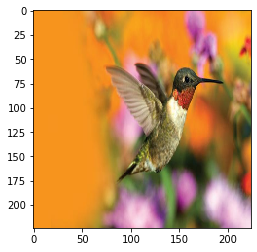

In [7]:
plt.imshow(resizedImage)

In [8]:
out = net(inputImage)
out = out.view(512, 7*7)
out = out.detach().numpy()

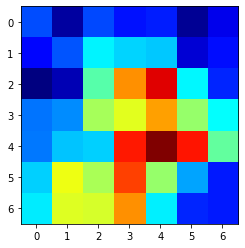

In [9]:
cam = getCam(weight[94], out)
plt.imshow(cam)

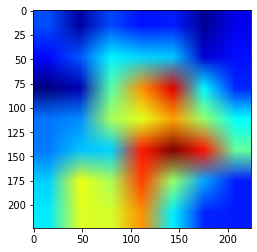

In [10]:
cam = cv2.resize(cam, (224,224))
plt.imshow(cam)

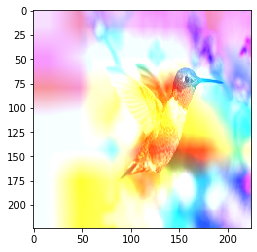

In [11]:
result = cv2.add(resizedImage, cam)
plt.imshow(result)

## Grad-CAM

In [12]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

In [13]:
featuresFn = nn.Sequential(*list(resnet.children())[:-2])
classifierFn = nn.Sequential(*(list(resnet.children())[-2:-1] + [Flatten()] + list(resnet.children())[-1:]))

In [14]:
feats = featuresFn(inputImage)
out = classifierFn(feats)
c_score = out[0, 94]
grads = torch.autograd.grad(c_score, feats)

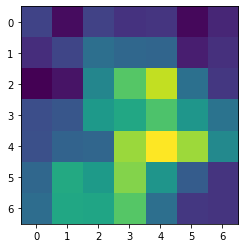

In [15]:
w = grads[0][0].mean(-1).mean(-1)
map = torch.matmul(w, feats.view(512, 7*7))
map = map.view(7, 7).cpu().detach().numpy()
# map = np.maximum(map, 0)
plt.imshow(map)

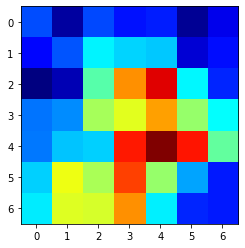

In [16]:
map = map - np.min(map)
map = map / np.max(map)
map = np.uint8(255 * map)
heatmap = cv2.applyColorMap(map, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
plt.imshow(heatmap)

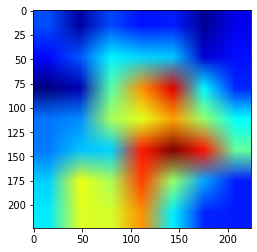

In [17]:
gradCam = cv2.resize(heatmap, (224,224))
plt.imshow(gradCam)

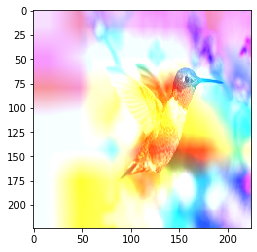

In [18]:
result = cv2.add(resizedImage, gradCam)
plt.imshow(result)

In [19]:
vgg = vgg11(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/checkpoints/vgg11-bbd30ac9.pth
99.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
featuresFn = nn.Sequential(*list(vgg.children())[0][:-2])
classifierFn = nn.Sequential(*([list(vgg.children())[0][-2:]] + [Flatten()] + list(vgg.children())[-1:]))

In [21]:
feats = featuresFn(inputImage)
out = classifierFn(feats)
c_score = out[0, 94]
print(feats.shape)
grads = torch.autograd.grad(c_score, feats)

torch.Size([1, 512, 14, 14])


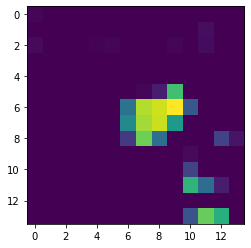

In [22]:
w = grads[0][0].mean(-1).mean(-1)
map = torch.matmul(w, feats.view(512, 14*14))
map = map.view(14, 14).cpu().detach().numpy()
map = np.maximum(map, 0)
plt.imshow(map)

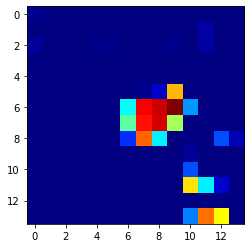

In [23]:
map = map - np.min(map)
map = map / np.max(map)
map = np.uint8(255 * map)
heatmap = cv2.applyColorMap(map, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
plt.imshow(heatmap)

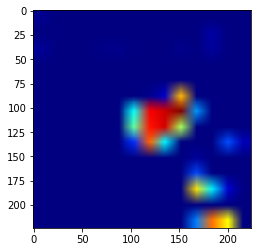

In [24]:
gradCam = cv2.resize(heatmap, (224,224))
plt.imshow(gradCam)

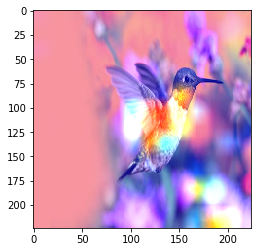

In [25]:
result = cv2.add(resizedImage, gradCam)
plt.imshow(result)